In [2]:
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report # Import confusion_matrix and classification_report
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping


In [4]:
# Data Loading and Preprocessing (Modified)
image_size = 150
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
X = []
Y = []

In [6]:
for label in labels:
    for folder in ['Training', 'Testing']:
        folder_path = os.path.join(folder, label)
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (image_size, image_size))
                X.append(img)  # Do not flatten here
                Y.append(label)

X = np.array(X)
Y = np.array(Y)

In [7]:
X, Y = shuffle(X, Y, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


X_train_scaled = X_train / 255.0
X_test_scaled = X_test / 255.0

In [8]:
# Label encoding
y_train_encoded = [labels.index(label) for label in y_train]
y_test_encoded = [labels.index(label) for label in y_test]
y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)

# Feature Flattening 
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [9]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


## RESNET 50V2 MODEL

In [14]:
# ResNet50V2 Model
base_resnet = ResNet50V2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
x = base_resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)

predictions = Dense(len(labels), activation='softmax')(x)
resnet_model = Model(inputs=base_resnet.input, outputs=predictions)

In [16]:
resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [18]:
resnet_history = resnet_model.fit(X_train_scaled, np.array(y_train_encoded), epochs=10, validation_data=(X_test_scaled, np.array(y_test_encoded)))
resnet_predictions = np.argmax(resnet_model.predict(X_test_scaled), axis=1)
resnet_accuracy = accuracy_score(y_test_encoded, resnet_predictions)
print(f"ResNet50V2 Accuracy: {resnet_accuracy}")


Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 381s 4s/step - accuracy: 0.6758 - loss: 0.8755 - val_accuracy: 0.4349 - val_loss: 83.2692
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 340s 4s/step - accuracy: 0.8294 - loss: 0.4898 - val_accuracy: 0.3354 - val_loss: 21.9929
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 398s 5s/step - accuracy: 0.8796 - loss: 0.3152 - val_accuracy: 0.8101 - val_loss: 0.6815
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 603s 7s/step - accuracy: 0.9435 - loss: 0.1740 - val_accuracy: 0.7243 - val_loss: 1.1503
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 316s 4s/step - accuracy: 0.9510 - loss: 0.1317 - val_accuracy: 0.5038 - val_loss: 2.8801
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 318s 4s/step - accuracy: 0.9473 - loss: 0.1620 - val_accuracy: 0.5773 - val_loss: 2.6645
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 315s 4s/step - accuracy: 0.9661 - loss: 0.1029 - val_accuracy: 0.8851 - val_loss: 0.3554
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 314s 4s/step - accuracy: 0.9755 - loss: 0.0668 - val_accuracy: 0.5957 -

In [20]:
cr_resnet=classification_report(y_test_encoded, resnet_predictions, target_names=labels)
print(cr_resnet)

                  precision    recall  f1-score   support

    glioma_tumor       0.84      0.89      0.87       206
meningioma_tumor       0.91      0.74      0.82       194
        no_tumor       0.85      0.80      0.82        94
 pituitary_tumor       0.83      0.99      0.90       159

        accuracy                           0.86       653
       macro avg       0.86      0.85      0.85       653
    weighted avg       0.86      0.86      0.85       653



In [22]:
# Confusion Matrix 
cm_resnet = confusion_matrix(y_test_encoded, resnet_predictions)
print("ResNet50V2 Confusion Matrix:")
print(cm_resnet)

ResNet50V2 Confusion Matrix:
[[183  11   7   5]
 [ 22 144   6  22]
 [ 10   3  75   6]
 [  2   0   0 157]]


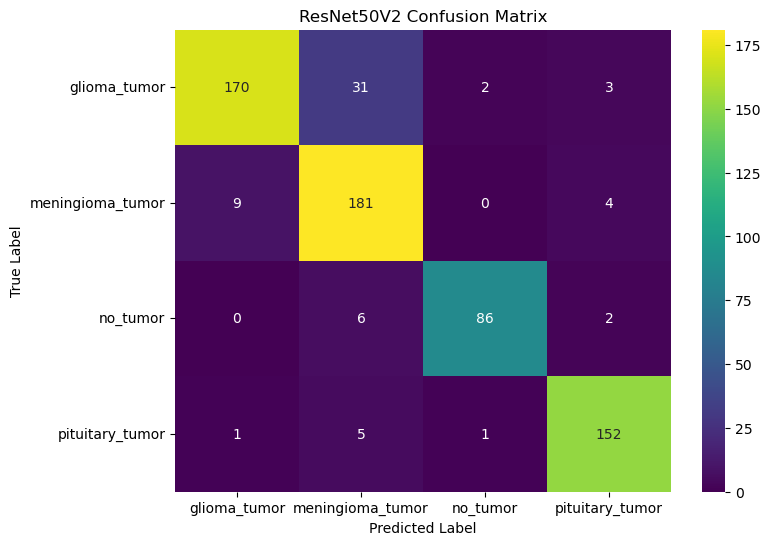

In [55]:
# Visualize Confusion Matrix 
plt.figure(figsize=(8, 6))
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='viridis',
            xticklabels=labels, yticklabels=labels)
plt.title('ResNet50V2 Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

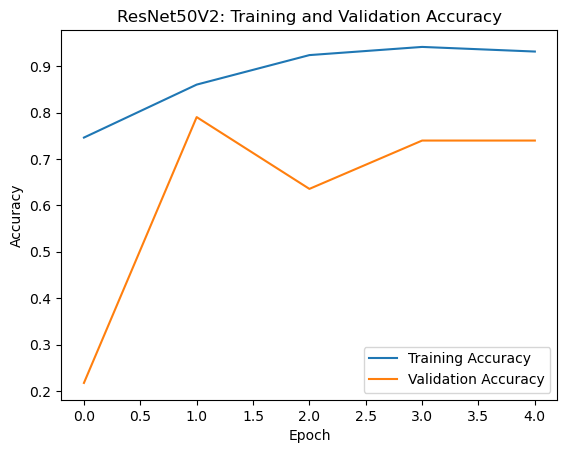

In [17]:
#Plot ResNet50V2 training history
plt.plot(resnet_history.history['accuracy'], label = "Training Accuracy")
plt.plot(resnet_history.history['val_accuracy'], label = "Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("ResNet50V2: Training and Validation Accuracy")
plt.show()

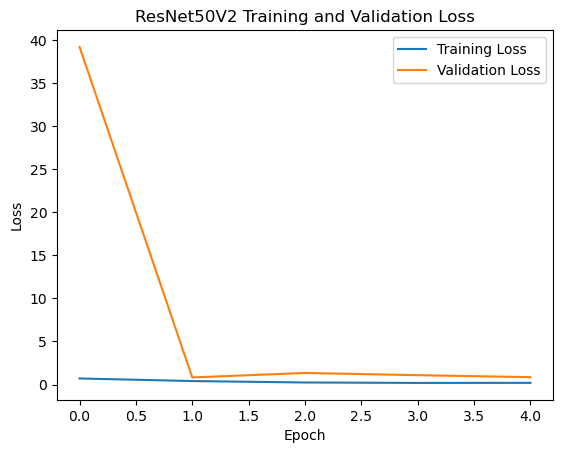

In [19]:
# Plot ResNet50V2 training loss
plt.plot(resnet_history.history['loss'], label='Training Loss')
plt.plot(resnet_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('ResNet50V2 Training and Validation Loss')
plt.show()

In [21]:
# Function to predict a single image using ResNet50V2
def predict_image_resnet(img_path, model):
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.resize(img, (image_size, image_size))
        img_scaled = np.expand_dims(img / 255.0, axis=0) # Scale and expand dims
        prediction = np.argmax(model.predict(img_scaled), axis=1)
        predicted_class = labels[prediction[0]]
        return predicted_class
    else:
        return "Error: Could not load image"

In [23]:
test_image_path_rs1= r"C:\Users\saisw\OneDrive\Desktop\brain tumor project\images.jpg"
predicted_label_rs1 = predict_image_resnet(test_image_path_rs1,resnet_model)
print(f"Predicted Label: {predicted_label_rs1}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Predicted Label: meningioma_tumor


In [25]:
test_image_path_rs2= r"C:\Users\saisw\OneDrive\Desktop\brain tumor project\Testing\glioma_tumor\image(5).jpg"
predicted_label_rs2 = predict_image_resnet(test_image_path_rs2,resnet_model)
print(f"Predicted Label: {predicted_label_rs2}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Predicted Label: glioma_tumor


In [29]:
test_image_path_rs3 = r"C:\Users\saisw\OneDrive\Desktop\Brain Tumor Detection Using Deep Learning\Testing\no_tumor\image(2).jpg"
predicted_label_rs3 = predict_image_resnet(test_image_path_rs3,resnet_model)
print(f"Predicted Label: {predicted_label_rs3}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Predicted Label: no_tumor


## InceptionV3 Model

In [14]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
from tensorflow.keras.applications.inception_v3 import decode_predictions as inception_decode

In [16]:
# InceptionV3 Model
base_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
x = base_inception.output
x = GlobalAveragePooling2D()(x)
predictions_inception = Dense(len(labels), activation='softmax')(x)
model_inception = Model(inputs=base_inception.input, outputs=predictions_inception)

In [18]:
model_inception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
incep_history=model_inception.fit(inception_preprocess(X_train), y_train_categorical, epochs=10, validation_data=(inception_preprocess(X_test), y_test_categorical),callbacks=[early_stop])

Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - accuracy: 0.7246 - loss: 0.7512 - val_accuracy: 0.3874 - val_loss: 53.7363
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step - accuracy: 0.9240 - loss: 0.2539 - val_accuracy: 0.7657 - val_loss: 0.7293
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.9430 - loss: 0.1679 - val_accuracy: 0.5865 - val_loss: 1.7267
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.9440 - loss: 0.1634 - val_accuracy: 0.4793 - val_loss: 1.8169
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - accuracy: 0.9599 - loss: 0.1141 - val_accuracy: 0.6355 - val_loss: 1.6224


In [20]:
inception_predictions_probabilities = model_inception.predict(inception_preprocess(X_test))

21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 651ms/step


In [22]:
inception_predictions = np.argmax(inception_predictions_probabilities, axis=1)

In [24]:
inception_accuracy = accuracy_score(y_test_encoded, inception_predictions)
print(f"InceptionV3 Accuracy: {inception_accuracy}")

InceptionV3 Accuracy: 0.7656967840735069


In [26]:
cr_inc = classification_report(y_test_encoded, inception_predictions, target_names=labels)
print("InceptionV3 Classification Report:\n", cr_inc)

InceptionV3 Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.93      0.84      0.88       206
meningioma_tumor       0.65      0.97      0.78       194
        no_tumor       0.70      0.94      0.80        94
 pituitary_tumor       1.00      0.31      0.48       159

        accuracy                           0.77       653
       macro avg       0.82      0.77      0.74       653
    weighted avg       0.83      0.77      0.74       653



In [28]:
cm_inc = confusion_matrix(y_test_encoded, inception_predictions)
print("InceptionV3 Confusion Matrix:")
print(cm_inc)

InceptionV3 Confusion Matrix:
[[173  25   8   0]
 [  3 189   2   0]
 [  0   6  88   0]
 [ 11  71  27  50]]


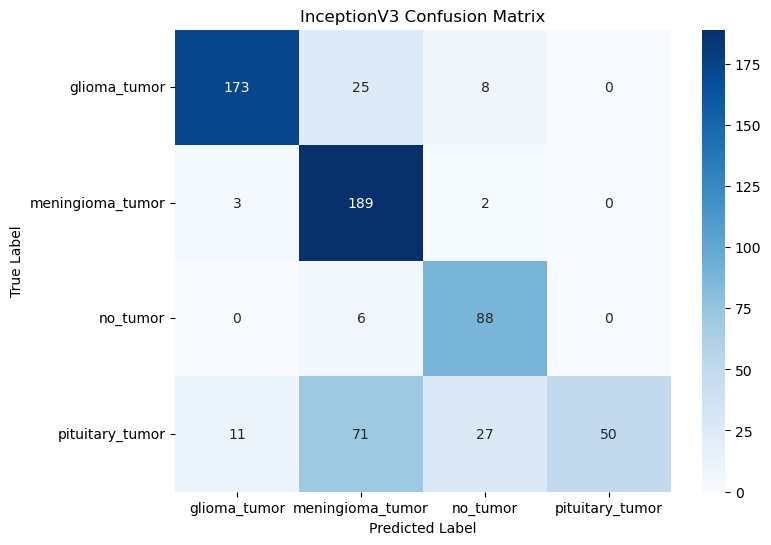

In [34]:
# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_inc, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('InceptionV3 Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

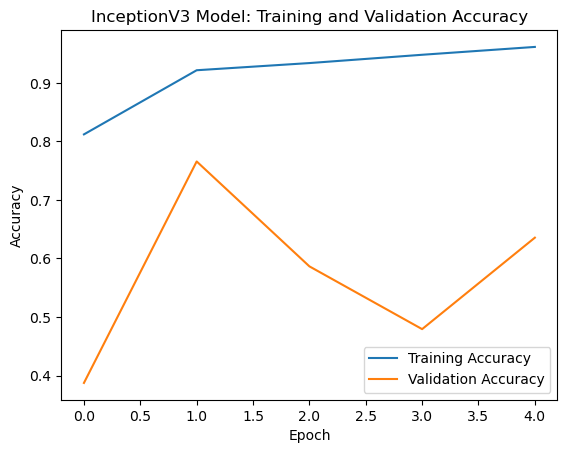

In [38]:
#Plot InceptionV3 training history
plt.plot(incep_history.history['accuracy'], label = "Training Accuracy")
plt.plot(incep_history.history['val_accuracy'], label = "Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("InceptionV3 Model: Training and Validation Accuracy")
plt.show()

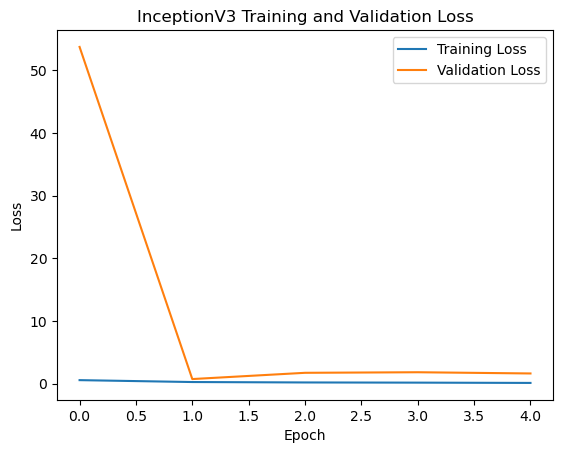

In [40]:
plt.plot(incep_history.history['loss'], label = "Training Loss")
plt.plot(incep_history.history['val_loss'], label = "Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("InceptionV3 Training and Validation Loss")
plt.show()

In [74]:

def predict_image_incep(img_path, model):
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.resize(img, (image_size, image_size))
        img_scaled = np.expand_dims(img / 255.0, axis=0) # Scale and expand dims
        prediction = np.argmax(model.predict(img_scaled), axis=1)
        predicted_class = labels[prediction[0]]
        return predicted_class
    else:
        return "Error: Could not load image"

In [76]:
test_image_path = r"C:\Users\saisw\OneDrive\Desktop\Brain Tumor Detection Using Deep Learning\Testing\no_tumor\image(2).jpg"
predicted_label = predict_image_incep(test_image_path,model_inception)
print(f"Predicted Label: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Predicted Label: no_tumor


In [78]:
test_image_path2= r"C:\Users\saisw\OneDrive\Desktop\brain tumor project\images.jpg"
predicted_label2 = predict_image_incep(test_image_path2,model_inception)
print(f"Predicted Label: {predicted_label2}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted Label: glioma_tumor


In [80]:
test_image_path3= r"C:\Users\saisw\OneDrive\Desktop\brain tumor project\Testing\glioma_tumor\image(5).jpg"
predicted_label3 = predict_image_incep(test_image_path3,model_inception)
print(f"Predicted Label: {predicted_label3}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted Label: meningioma_tumor


In [82]:
test_image_path4= r"C:\Users\saisw\OneDrive\Desktop\brain tumor project\google_image2.jpg"
predicted_label4 = predict_image_incep(test_image_path4,model_inception)
print(f"Predicted Label: {predicted_label4}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted Label: pituitary_tumor


In [84]:
test_image_path5= r"C:\Users\saisw\OneDrive\Desktop\brain tumor project\google_image3.jpg"
predicted_label5 = predict_image_incep(test_image_path5,model_inception)
print(f"Predicted Label: {predicted_label5}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted Label: meningioma_tumor


## CNN Model

In [15]:
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(labels), activation='softmax')
])

C:\Users\saisw\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [19]:
cnn_history = cnn_model.fit(
    X_train_scaled,
    np.array(y_train_encoded),
    epochs=20,
    validation_data=(X_test_scaled, np.array(y_test_encoded)),
    callbacks=[early_stop]
)


Epoch 1/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 37s 412ms/step - accuracy: 0.4534 - loss: 1.2574 - val_accuracy: 0.6141 - val_loss: 0.9152
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 43s 433ms/step - accuracy: 0.6631 - loss: 0.8098 - val_accuracy: 0.7534 - val_loss: 0.6544
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 32s 386ms/step - accuracy: 0.7596 - loss: 0.6276 - val_accuracy: 0.7672 - val_loss: 0.5812
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 40s 377ms/step - accuracy: 0.8028 - loss: 0.5300 - val_accuracy: 0.8254 - val_loss: 0.4515
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 34s 414ms/step - accuracy: 0.8514 - loss: 0.3861 - val_accuracy: 0.8515 - val_loss: 0.4091
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 33s 402ms/step - accuracy: 0.8993 - loss: 0.2833 - val_accuracy: 0.8729 - val_loss: 0.3635
Epoch 7/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 35s 327ms/step - accuracy: 0.9121 - loss: 0.2342 - val_accuracy: 0.8821 - val_loss: 0.3090
Epoch 8/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 29s 351ms/step - accuracy: 0.9107 - loss: 0.2496 - val_accu

In [21]:
cnn_predictions = np.argmax(cnn_model.predict(X_test_scaled), axis=1)
cnn_accuracy = accuracy_score(y_test_encoded, cnn_predictions)
print(f"CNN Accuracy: {cnn_accuracy}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step
CNN Accuracy: 0.9310872894333844


In [23]:
cr_cnn = classification_report(y_test_encoded, cnn_predictions, target_names=labels)
print("CNN Classification Report:\n", cr_cnn)


CNN Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.96      0.89      0.92       170
meningioma_tumor       0.91      0.92      0.92       182
        no_tumor       0.91      0.92      0.92       119
 pituitary_tumor       0.95      0.98      0.96       182

        accuracy                           0.93       653
       macro avg       0.93      0.93      0.93       653
    weighted avg       0.93      0.93      0.93       653



In [25]:
cm_cnn = confusion_matrix(y_test_encoded, cnn_predictions)
print("CNN Confusion Matrix:")
print(cm_cnn)

CNN Confusion Matrix:
[[152   9   7   2]
 [  3 168   4   7]
 [  3   5 110   1]
 [  1   3   0 178]]


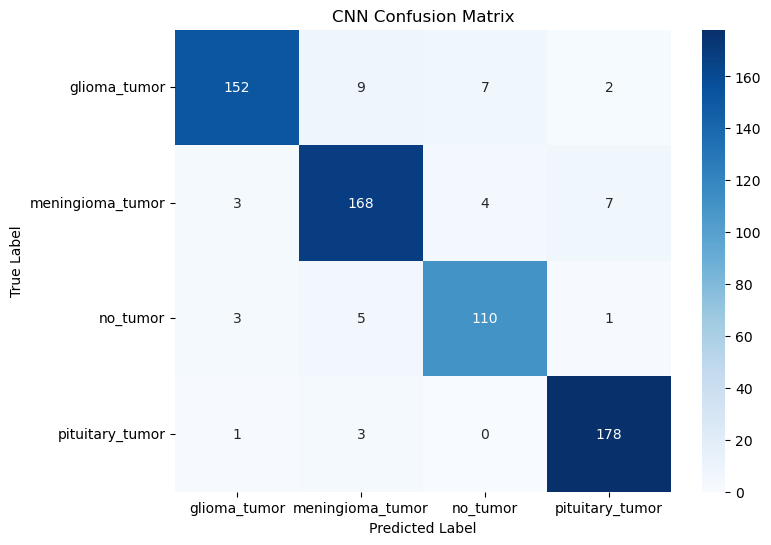

In [35]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt='d',cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('CNN Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

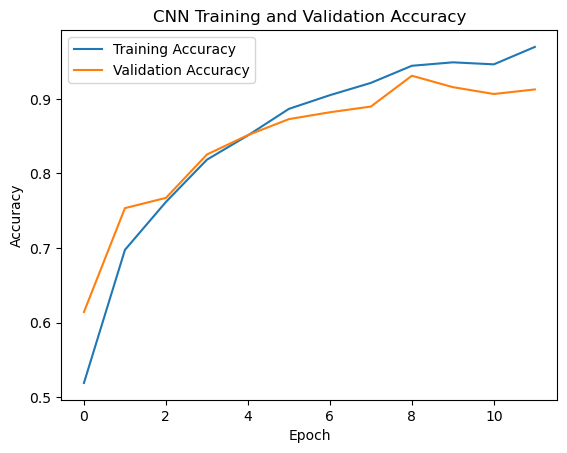

In [37]:
plt.plot(cnn_history.history['accuracy'], label = "Training Accuracy")
plt.plot(cnn_history.history['val_accuracy'], label = "Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("CNN Training and Validation Accuracy")
plt.show()

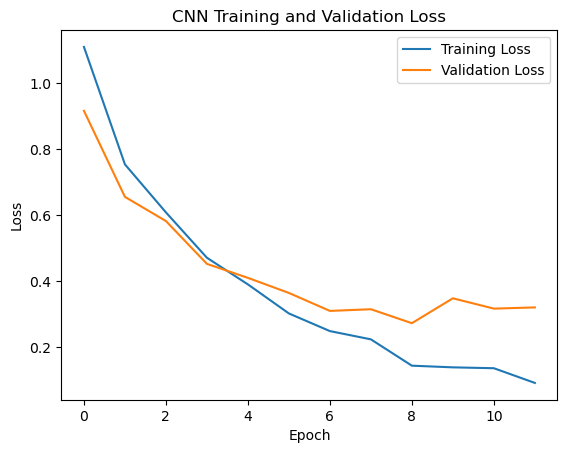

In [39]:
plt.plot(cnn_history.history['loss'], label = "Training Loss")
plt.plot(cnn_history.history['val_loss'], label = "Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("CNN Training and Validation Loss")
plt.show()

In [114]:
def predict_image_cnn(img_path, model):
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.resize(img, (image_size, image_size))
        img_scaled = np.expand_dims(img / 255.0, axis=0) # Scale and expand dims
        prediction = np.argmax(model.predict(img_scaled), axis=1)
        predicted_class = labels[prediction[0]]
        return predicted_class
    else:
        return "Error: Could not load image"

In [116]:
test_image_path = r"C:\Users\saisw\OneDrive\Desktop\Brain Tumor Detection Using Deep Learning\Testing\no_tumor\image(2).jpg"
predicted_label = predict_image_cnn(test_image_path,cnn_model)
print(f"Predicted Label: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted Label: no_tumor


In [118]:
test_image_path2= r"C:\Users\saisw\OneDrive\Desktop\brain tumor project\images.jpg"
predicted_label2 = predict_image_cnn(test_image_path2,cnn_model)
print(f"Predicted Label: {predicted_label2}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Label: meningioma_tumor


In [120]:
test_image_path3= r"C:\Users\saisw\OneDrive\Desktop\brain tumor project\Testing\glioma_tumor\image(5).jpg"
predicted_label3 = predict_image_cnn(test_image_path3,cnn_model)
print(f"Predicted Label: {predicted_label3}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted Label: glioma_tumor


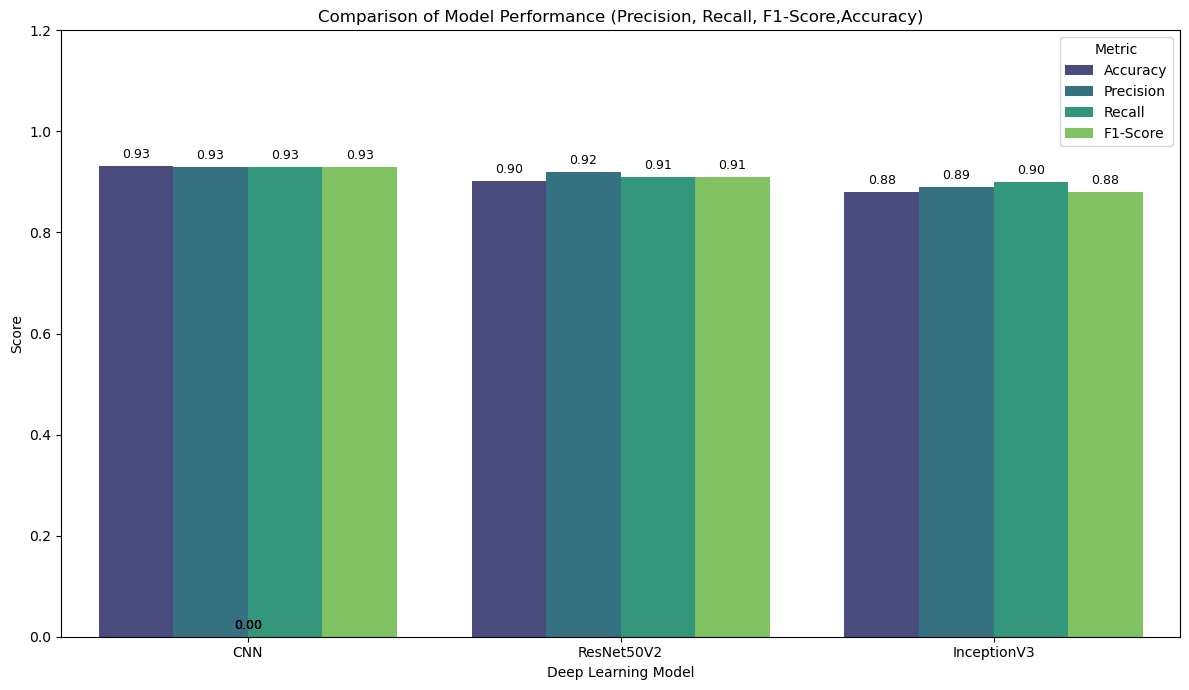

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Sample data (replace with your actual model names and scores)
model_performance = {
    'CNN': {'Accuracy':0.931 ,'Precision': 0.93, 'Recall': 0.93, 'F1-Score': 0.93},
    'ResNet50V2': {'Accuracy': 0.901,'Precision': 0.92, 'Recall': 0.91, 'F1-Score': 0.91},
    'InceptionV3': {'Accuracy': 0.88,'Precision': 0.89, 'Recall': 0.90, 'F1-Score': 0.88}
}

# Convert the dictionary to a long format DataFrame for easier plotting with seaborn
data = []
for model, scores in model_performance.items():
    data.append({'Model': model, 'Metric': 'Accuracy', 'Value': scores['Accuracy']})
    data.append({'Model': model, 'Metric': 'Precision', 'Value': scores['Precision']})
    data.append({'Model': model, 'Metric': 'Recall', 'Value': scores['Recall']})
    data.append({'Model': model, 'Metric': 'F1-Score', 'Value': scores['F1-Score']})
    

df = pd.DataFrame(data)

# Create the grouped bar plot
plt.figure(figsize=(12, 7))
sns.barplot(x='Model', y='Value', hue='Metric', data=df, palette='viridis')

# Add labels and title
plt.xlabel('Deep Learning Model')
plt.ylabel('Score')
plt.title('Comparison of Model Performance (Precision, Recall, F1-Score,Accuracy)')
plt.ylim(0, 1.2)  # Set y-axis limits to 0 and 1

# Add value labels on top of the bars
for p in plt.gca().patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width()/2., height + 0.01, f'{height:.2f}',
            ha='center', va='bottom', fontsize=9)

# Adjust the legend
plt.legend(title='Metric')

# Show the plot
plt.tight_layout()
plt.show()

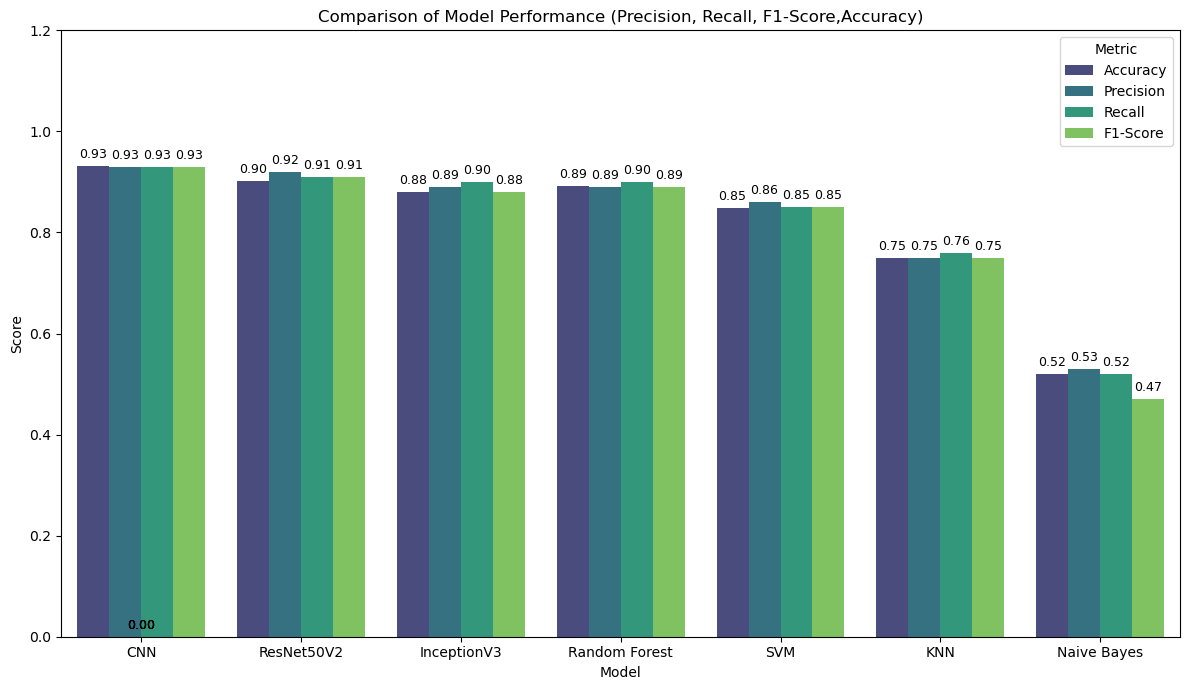

<Figure size 640x480 with 0 Axes>

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Sample data (replace with your actual model names and scores)
model_performance = { 
    'CNN': {'Accuracy':0.931 ,'Precision': 0.93, 'Recall': 0.93, 'F1-Score': 0.93},
    'ResNet50V2': {'Accuracy': 0.901,'Precision': 0.92, 'Recall': 0.91, 'F1-Score': 0.91},
    'InceptionV3': {'Accuracy': 0.88,'Precision': 0.89, 'Recall': 0.90, 'F1-Score': 0.88},
    'Random Forest': {'Accuracy':0.892 ,'Precision': 0.89, 'Recall': 0.90, 'F1-Score': 0.89},
    'SVM': {'Accuracy':0.848 ,'Precision': 0.86, 'Recall': 0.85, 'F1-Score': 0.85},
    'KNN': {'Accuracy': 0.75,'Precision': 0.75, 'Recall': 0.76, 'F1-Score': 0.75},
    'Naive Bayes': {'Accuracy': 0.52,'Precision': 0.53, 'Recall': 0.52, 'F1-Score': 0.47}
}

# Convert the dictionary to a long format DataFrame for easier plotting with seaborn
data = []
for model, scores in model_performance.items():
    data.append({'Model': model, 'Metric': 'Accuracy', 'Value': scores['Accuracy']})
    data.append({'Model': model, 'Metric': 'Precision', 'Value': scores['Precision']})
    data.append({'Model': model, 'Metric': 'Recall', 'Value': scores['Recall']})
    data.append({'Model': model, 'Metric': 'F1-Score', 'Value': scores['F1-Score']})
    

df = pd.DataFrame(data)

# Create the grouped bar plot
plt.figure(figsize=(12, 7))
sns.barplot(x='Model', y='Value', hue='Metric', data=df, palette='viridis')

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Comparison of Model Performance (Precision, Recall, F1-Score,Accuracy)')
plt.ylim(0, 1.2)  # Set y-axis limits to 0 and 1

# Add value labels on top of the bars
for p in plt.gca().patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width()/2., height + 0.01, f'{height:.2f}',
            ha='center', va='bottom', fontsize=9)

# Adjust the legend
plt.legend(title='Metric')

# Show the plot
plt.tight_layout()
plt.show() 
plt.savefig('my_plot.png') 